# Typechecking performance analysis

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy

# Set up matplotlib for better plots in Jupyter
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [74]:
# Cell 2: Load and examine the data
def load_strata_results(csv_file="strata_verify_results.csv"):
    """Load StrataVerify benchmark results from CSV file."""
    
    if not os.path.exists(csv_file):
        print(f"Error: CSV file '{csv_file}' not found")
        return None
    
    try:
        df = pd.read_csv(csv_file)
        print(f"✅ Loaded {len(df)} results from {csv_file}")
        return df
    except Exception as e:
        print(f"❌ Error reading CSV file: {e}")
        return None

# Load the data
df = load_strata_results("strata_verify_results_typechecking_only.csv")

# Display basic info about the dataset
if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    display(df.head())



✅ Loaded 9 results from strata_verify_results_typechecking_only.csv

Dataset shape: (9, 3)
Columns: ['filename', 'line_count', 'execution_time_seconds']


,filename,line_count,execution_time_seconds
0,ContainerHeapAffine12.boogie.st,292,65.578864
1,ContainerHeapAffine20.boogie.st,337,99.062512
2,ContainerHeapAffine4.boogie.st,248,41.058522
3,ContainerHeapAffine8.boogie.st,270,52.702717
4,ContainerHeapClassic12.boogie.st,283,229.493657


In [75]:
if df is not None:
    print("📊 SUMMARY STATISTICS")
    print("=" * 50)
    print(f"Total files processed: {len(df)}")
    print(f"Average execution time: {df['execution_time_seconds'].mean():.2f}s")
    print(f"Median execution time: {df['execution_time_seconds'].median():.2f}s")
    print(f"Standard deviation: {df['execution_time_seconds'].std():.2f}s")
    print(f"Slowest file: {df.loc[df['execution_time_seconds'].idxmax(), 'filename']} ({df['execution_time_seconds'].max():.2f}s)")
    print(f"Fastest file: {df.loc[df['execution_time_seconds'].idxmin(), 'filename']} ({df['execution_time_seconds'].min():.2f}s)")
    print(f"Average file size: {df['line_count'].mean():.0f} lines")
    print(f"Largest file: {df.loc[df['line_count'].idxmax(), 'filename']} ({df['line_count'].max()} lines)")
    
    # Display descriptive statistics
    print("\n📈 Detailed Statistics:")
    display(df[['line_count', 'execution_time_seconds']].describe())

📊 SUMMARY STATISTICS
Total files processed: 9
Average execution time: 144.13s
Median execution time: 95.12s
Standard deviation: 157.49s
Slowest file: ContainerHeapClassic20.boogie.st (537.20s)
Fastest file: ContainerHeapAffine4.boogie.st (41.06s)
Average file size: 278 lines
Largest file: ContainerHeapAffine20.boogie.st (337 lines)

📈 Detailed Statistics:


,line_count,execution_time_seconds
count,9.000000,9.000000
mean,278.333333,144.130370
std,34.867607,157.489298
min,238.000000,41.058522
25%,254.000000,65.578864
50%,270.000000,95.121429
75%,292.000000,109.089784
max,337.000000,537.202279


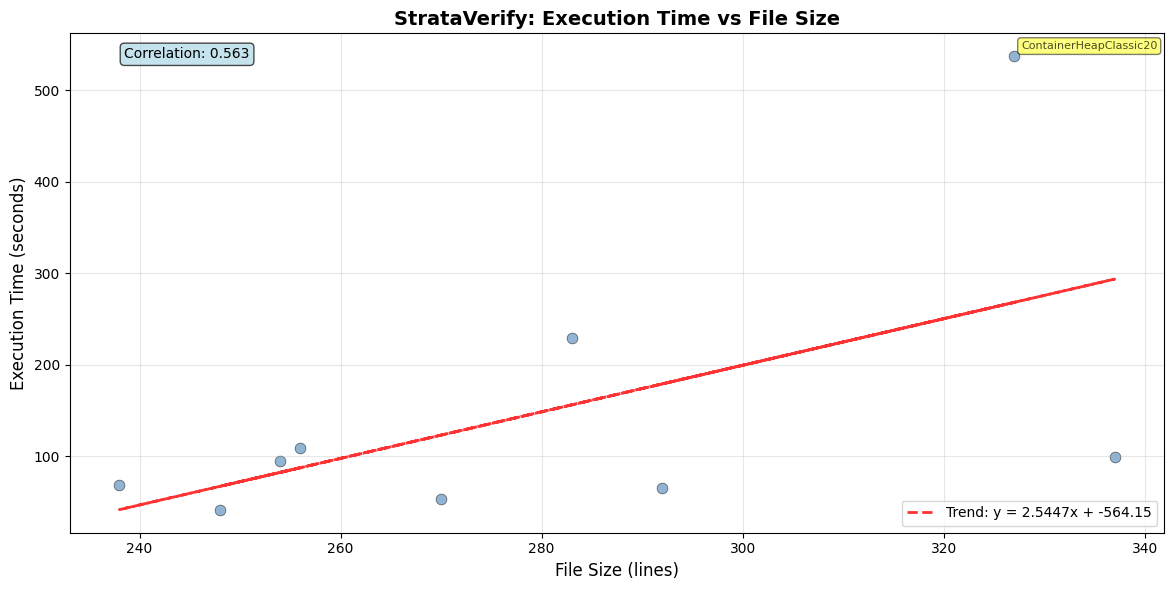

In [76]:
if df is not None:
    plt.figure(figsize=(12, 6))
    
    # Create scatter plot
    plt.scatter(df['line_count'], df['execution_time_seconds'], 
                alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(df['line_count'], df['execution_time_seconds'], 1)
    p = np.poly1d(z)
    plt.plot(df['line_count'], p(df['line_count']), "r--", alpha=0.8, linewidth=2,
             label=f'Trend: y = {z[0]:.4f}x + {z[1]:.2f}')
    
    # Annotate outliers (top 10% slowest)
    threshold = df['execution_time_seconds'].quantile(0.9)
    outliers = df[df['execution_time_seconds'] > threshold]
    
    for _, row in outliers.iterrows():
        plt.annotate(row['filename'].replace('.boogie.st', ''), 
                    (row['line_count'], row['execution_time_seconds']),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.7,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    
    plt.xlabel('File Size (lines)', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.title('StrataVerify: Execution Time vs File Size', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Calculate correlation
    correlation = df['line_count'].corr(df['execution_time_seconds'])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

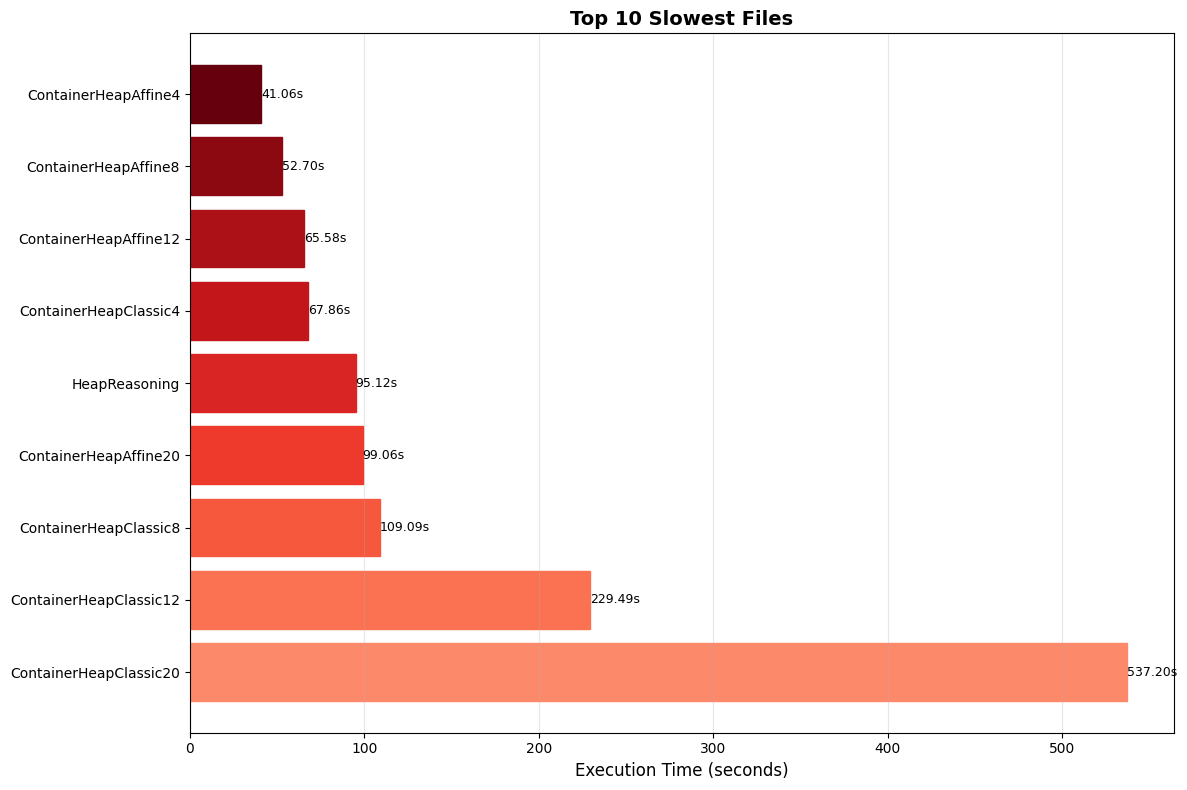

In [77]:
if df is not None:
    plt.figure(figsize=(12, 8))
    
    top_slow = df.nlargest(10, 'execution_time_seconds')
    
    # Create horizontal bar chart
    bars = plt.barh(range(len(top_slow)), top_slow['execution_time_seconds'])
    
    # Color bars by execution time (gradient)
    colors = plt.cm.Reds(np.linspace(0.4, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Customize the plot
    plt.yticks(range(len(top_slow)), 
               [f.replace('.boogie.st', '') for f in top_slow['filename']])
    plt.xlabel('Execution Time (seconds)', fontsize=12)
    plt.title('Top 10 Slowest Files', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (bar, time) in enumerate(zip(bars, top_slow['execution_time_seconds'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{time:.2f}s', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

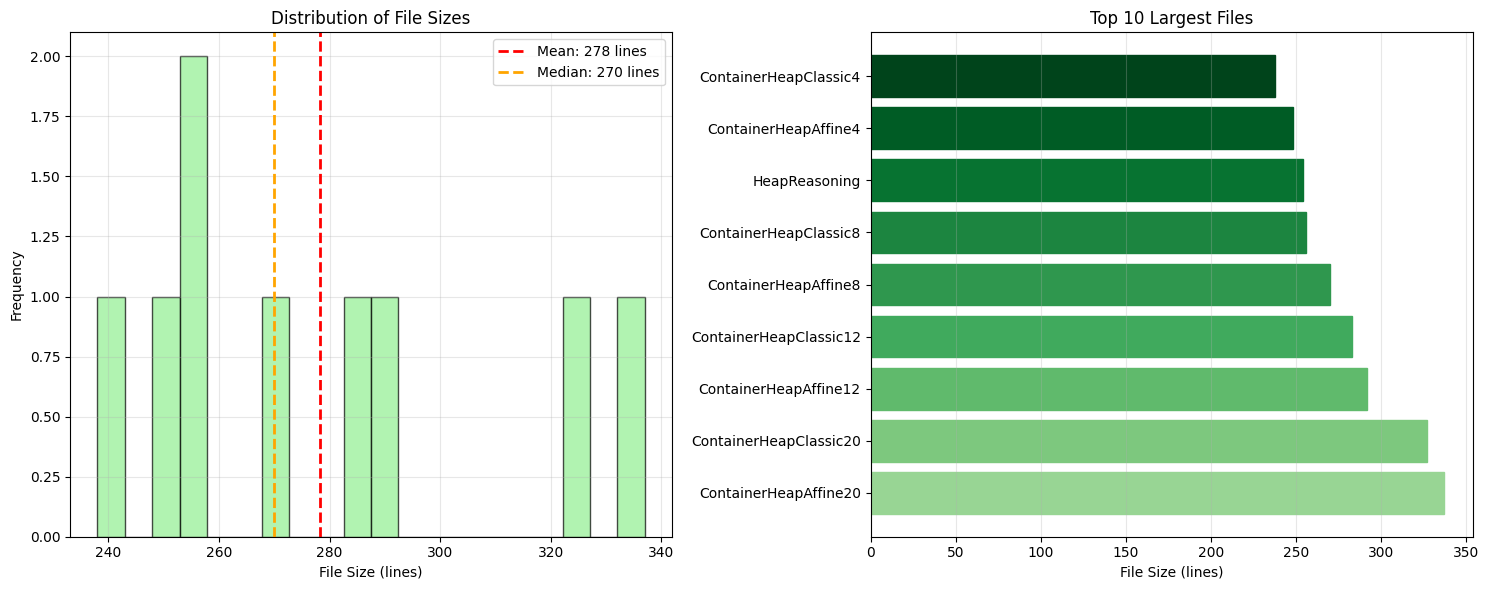

In [78]:
if df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # File size histogram
    ax1.hist(df['line_count'], bins=20, alpha=0.7, 
             color='lightgreen', edgecolor='black')
    ax1.axvline(df['line_count'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["line_count"].mean():.0f} lines')
    ax1.axvline(df['line_count'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {df["line_count"].median():.0f} lines')
    ax1.set_xlabel('File Size (lines)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of File Sizes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Largest files
    top_large = df.nlargest(10, 'line_count')
    bars = ax2.barh(range(len(top_large)), top_large['line_count'])
    
    colors = plt.cm.Greens(np.linspace(0.4, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax2.set_yticks(range(len(top_large)))
    ax2.set_yticklabels([f.replace('.boogie.st', '') for f in top_large['filename']])
    ax2.set_xlabel('File Size (lines)')
    ax2.set_title('Top 10 Largest Files')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


<Figure size 1600x800 with 0 Axes>

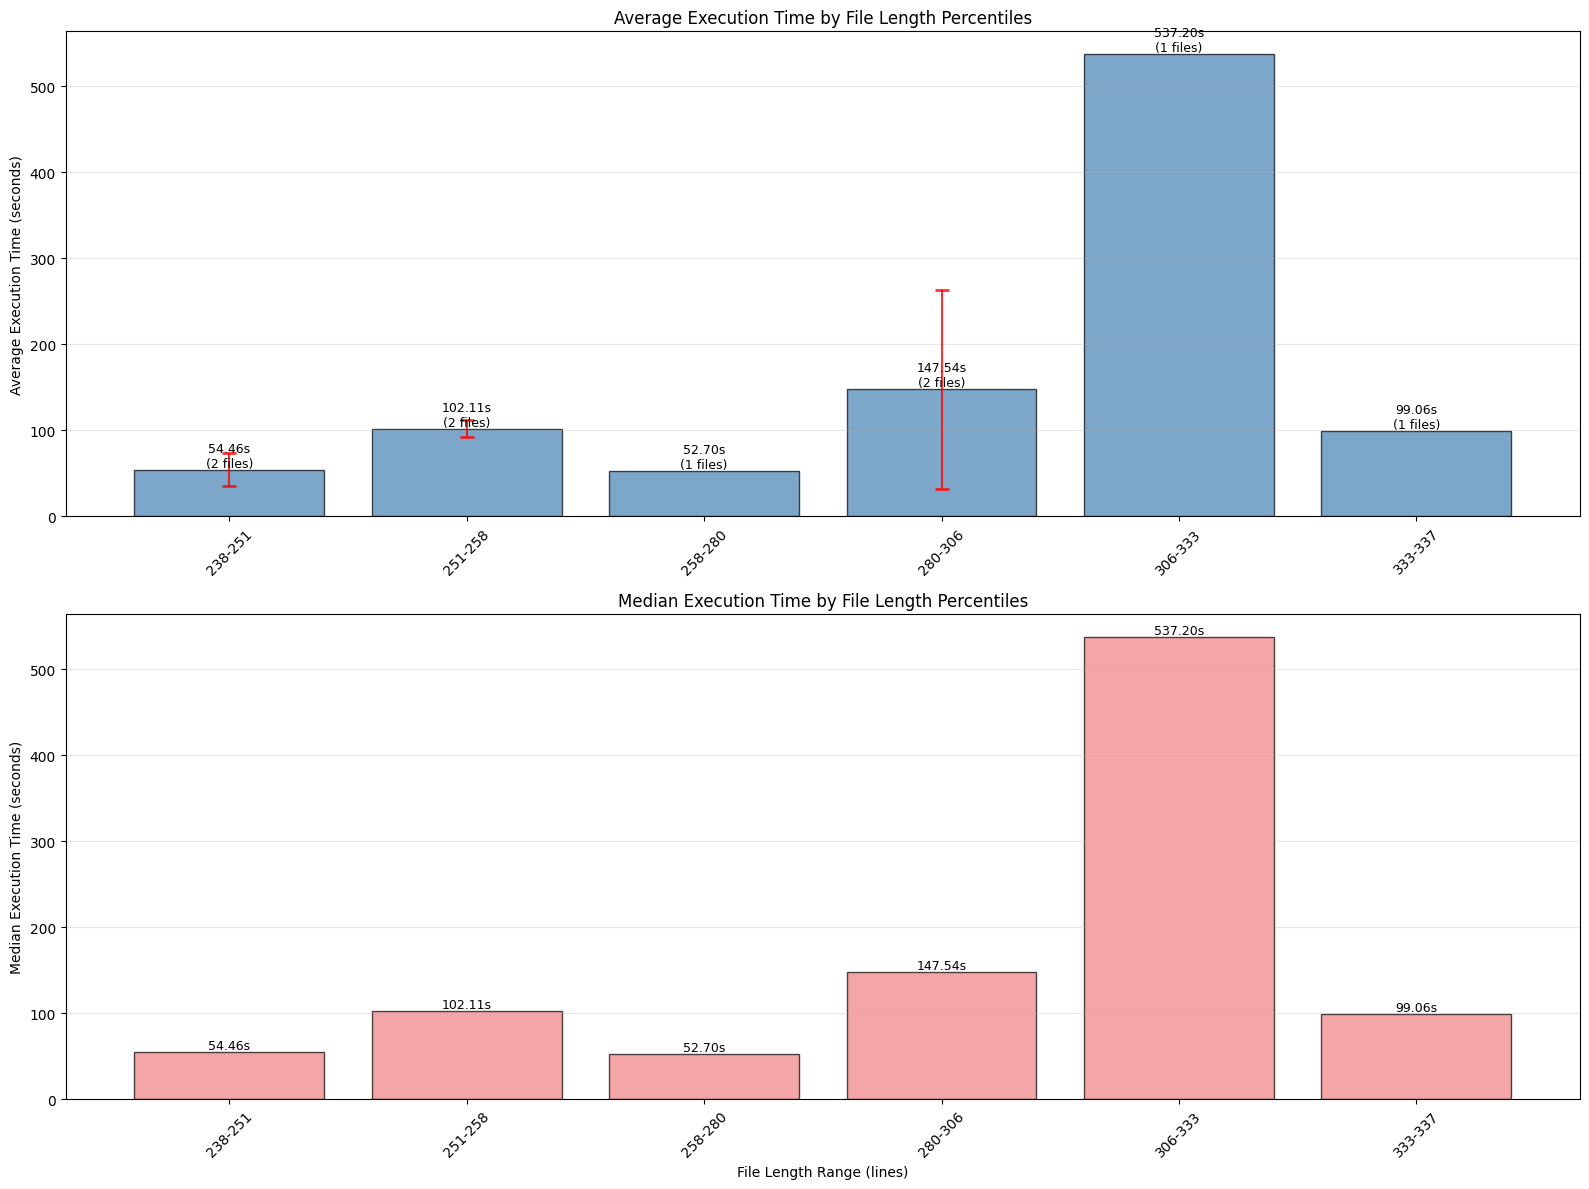

📊 Detailed Statistics by File Length Percentiles:


,length_percentile,avg_time,median_time,std_time,file_count,avg_lines,min_lines,max_lines
0,238-251,54.461,54.461,18.954,2,243.0,238,248
1,251-258,102.106,102.106,9.877,2,255.0,254,256
2,258-280,52.703,52.703,NaN,1,270.0,270,270
3,280-306,147.536,147.536,115.905,2,287.5,283,292
4,306-333,537.202,537.202,NaN,1,327.0,327,327
5,333-337,99.063,99.063,NaN,1,337.0,337,337


In [79]:
if df is not None:
    plt.figure(figsize=(16, 8))
    
    # Create more granular bins based on data distribution
    percentiles = [0, 20, 40, 60, 80, 95, 100]
    bin_edges = [df['line_count'].quantile(p/100) for p in percentiles]
    
    # Ensure unique bin edges
    bin_edges = sorted(list(set(bin_edges)))
    
    # Create labels for bins
    labels = []
    for i in range(len(bin_edges)-1):
        labels.append(f"{int(bin_edges[i])}-{int(bin_edges[i+1])}")
    
    # Assign files to categories
    df['length_percentile'] = pd.cut(df['line_count'], bins=bin_edges, labels=labels, include_lowest=True)
    
    # Calculate statistics
    percentile_stats = df.groupby('length_percentile', observed=True).agg({
        'execution_time_seconds': ['mean', 'median', 'std', 'count'],
        'line_count': ['mean', 'min', 'max']
    }).round(3)
    
    # Flatten column names
    percentile_stats.columns = ['avg_time', 'median_time', 'std_time', 'file_count', 
                               'avg_lines', 'min_lines', 'max_lines']
    percentile_stats = percentile_stats.reset_index()
    
    # Remove empty categories
    percentile_stats = percentile_stats[percentile_stats['file_count'] > 0]
    
    # Create subplot with both average and median
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot 1: Average time with error bars
    bars1 = ax1.bar(range(len(percentile_stats)), percentile_stats['avg_time'], 
                     alpha=0.7, color='steelblue', edgecolor='black')
    ax1.errorbar(range(len(percentile_stats)), percentile_stats['avg_time'], 
                yerr=percentile_stats['std_time'], fmt='none', color='red', 
                capsize=5, capthick=2, alpha=0.8)
    
    ax1.set_ylabel('Average Execution Time (seconds)')
    ax1.set_title('Average Execution Time by File Length Percentiles')
    ax1.set_xticks(range(len(percentile_stats)))
    ax1.set_xticklabels(percentile_stats['length_percentile'], rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add labels
    for i, (bar, avg_time, count) in enumerate(zip(bars1, percentile_stats['avg_time'], percentile_stats['file_count'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{avg_time:.2f}s\n({count} files)', 
                ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Median time (more robust to outliers)
    bars2 = ax2.bar(range(len(percentile_stats)), percentile_stats['median_time'], 
                     alpha=0.7, color='lightcoral', edgecolor='black')
    
    ax2.set_xlabel('File Length Range (lines)')
    ax2.set_ylabel('Median Execution Time (seconds)')
    ax2.set_title('Median Execution Time by File Length Percentiles')
    ax2.set_xticks(range(len(percentile_stats)))
    ax2.set_xticklabels(percentile_stats['length_percentile'], rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add labels
    for i, (bar, median_time) in enumerate(zip(bars2, percentile_stats['median_time'])):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{median_time:.2f}s', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display detailed table
    print("📊 Detailed Statistics by File Length Percentiles:")
    display(percentile_stats)

📊 Found 4 'classic' files and 4 'affine' files


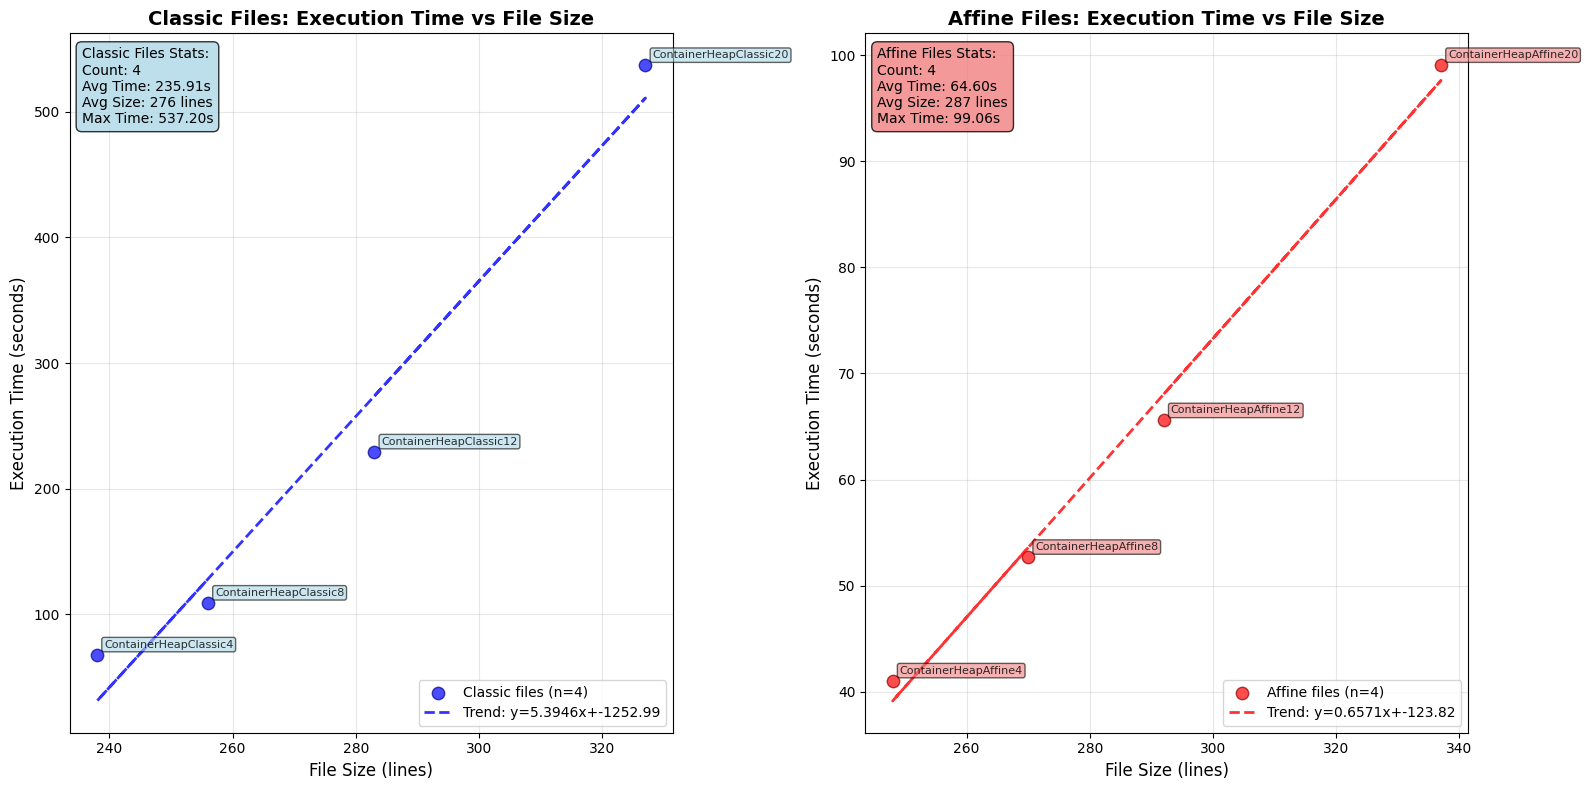


🔍 COMPARATIVE ANALYSIS


,Metric,Classic Files,Affine Files
0,Count,4,4
1,Avg Execution Time (s),235.912,64.601
2,Median Execution Time (s),169.292,59.141
3,Avg File Size (lines),276.0,286.8
4,Median File Size (lines),269.5,281.0
5,Max Execution Time (s),537.202,99.063
6,Min Execution Time (s),67.864,41.059
7,Avg Time per Line (s/line),0.791256,0.219823



📈 Statistical Test (t-test for execution times):
t-statistic: 1.6032
p-value: 0.1600
❌ No statistically significant difference (p ≥ 0.05)

📋 Classic Files Details:


,filename,line_count,execution_time_seconds
5,ContainerHeapClassic20.boogie.st,327,537.202279
4,ContainerHeapClassic12.boogie.st,283,229.493657
7,ContainerHeapClassic8.boogie.st,256,109.089784
6,ContainerHeapClassic4.boogie.st,238,67.863569



📋 Affine Files Details:


,filename,line_count,execution_time_seconds
1,ContainerHeapAffine20.boogie.st,337,99.062512
0,ContainerHeapAffine12.boogie.st,292,65.578864
3,ContainerHeapAffine8.boogie.st,270,52.702717
2,ContainerHeapAffine4.boogie.st,248,41.058522


In [80]:
if df is not None:
    # Filter files by name patterns (case insensitive)
    classic_files = df[df['filename'].str.contains('classic', case=False, na=False)]
    affine_files = df[df['filename'].str.contains('affine', case=False, na=False)]
    
    print(f"📊 Found {len(classic_files)} 'classic' files and {len(affine_files)} 'affine' files")
    
    if len(classic_files) > 0 or len(affine_files) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot 1: Classic files - Execution time vs File size
        if len(classic_files) > 0:
            scatter1 = ax1.scatter(classic_files['line_count'], classic_files['execution_time_seconds'], 
                                  alpha=0.7, s=80, c='blue', edgecolors='darkblue', linewidth=1,
                                  label=f'Classic files (n={len(classic_files)})')
            
            # Add trend line for classic files
            if len(classic_files) > 1:
                z1 = np.polyfit(classic_files['line_count'], classic_files['execution_time_seconds'], 1)
                p1 = np.poly1d(z1)
                ax1.plot(classic_files['line_count'], p1(classic_files['line_count']), 
                        "b--", alpha=0.8, linewidth=2,
                        label=f'Trend: y={z1[0]:.4f}x+{z1[1]:.2f}')
            
            # Annotate points with filenames
            for _, row in classic_files.iterrows():
                ax1.annotate(row['filename'].replace('.boogie.st', '').replace('classic', 'C'), 
                           (row['line_count'], row['execution_time_seconds']),
                           xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, alpha=0.8,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.6))
            
            ax1.set_xlabel('File Size (lines)', fontsize=12)
            ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
            ax1.set_title('Classic Files: Execution Time vs File Size', fontsize=14, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # Add statistics text box
            classic_stats = f"""Classic Files Stats:
Count: {len(classic_files)}
Avg Time: {classic_files['execution_time_seconds'].mean():.2f}s
Avg Size: {classic_files['line_count'].mean():.0f} lines
Max Time: {classic_files['execution_time_seconds'].max():.2f}s"""
            
            ax1.text(0.02, 0.98, classic_stats, transform=ax1.transAxes, 
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))
        else:
            ax1.text(0.5, 0.5, 'No files with "classic" found', 
                    transform=ax1.transAxes, ha='center', va='center', fontsize=14)
            ax1.set_title('Classic Files: No Data', fontsize=14, fontweight='bold')
        
        # Plot 2: Affine files - Execution time vs File size
        if len(affine_files) > 0:
            scatter2 = ax2.scatter(affine_files['line_count'], affine_files['execution_time_seconds'], 
                                  alpha=0.7, s=80, c='red', edgecolors='darkred', linewidth=1,
                                  label=f'Affine files (n={len(affine_files)})')
            
            # Add trend line for affine files
            if len(affine_files) > 1:
                z2 = np.polyfit(affine_files['line_count'], affine_files['execution_time_seconds'], 1)
                p2 = np.poly1d(z2)
                ax2.plot(affine_files['line_count'], p2(affine_files['line_count']), 
                        "r--", alpha=0.8, linewidth=2,
                        label=f'Trend: y={z2[0]:.4f}x+{z2[1]:.2f}')
            
            # Annotate points with filenames
            for _, row in affine_files.iterrows():
                ax2.annotate(row['filename'].replace('.boogie.st', '').replace('affine', 'A'), 
                           (row['line_count'], row['execution_time_seconds']),
                           xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, alpha=0.8,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="lightcoral", alpha=0.6))
            
            ax2.set_xlabel('File Size (lines)', fontsize=12)
            ax2.set_ylabel('Execution Time (seconds)', fontsize=12)
            ax2.set_title('Affine Files: Execution Time vs File Size', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            
            # Add statistics text box
            affine_stats = f"""Affine Files Stats:
Count: {len(affine_files)}
Avg Time: {affine_files['execution_time_seconds'].mean():.2f}s
Avg Size: {affine_files['line_count'].mean():.0f} lines
Max Time: {affine_files['execution_time_seconds'].max():.2f}s"""
            
            ax2.text(0.02, 0.98, affine_stats, transform=ax2.transAxes, 
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))
        else:
            ax2.text(0.5, 0.5, 'No files with "affine" found', 
                    transform=ax2.transAxes, ha='center', va='center', fontsize=14)
            ax2.set_title('Affine Files: No Data', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Comparative analysis
        if len(classic_files) > 0 and len(affine_files) > 0:
            print("\n🔍 COMPARATIVE ANALYSIS")
            print("=" * 50)
            
            comparison_data = {
                'Metric': ['Count', 'Avg Execution Time (s)', 'Median Execution Time (s)', 
                          'Avg File Size (lines)', 'Median File Size (lines)', 
                          'Max Execution Time (s)', 'Min Execution Time (s)',
                          'Avg Time per Line (s/line)'],
                'Classic Files': [
                    len(classic_files),
                    f"{classic_files['execution_time_seconds'].mean():.3f}",
                    f"{classic_files['execution_time_seconds'].median():.3f}",
                    f"{classic_files['line_count'].mean():.1f}",
                    f"{classic_files['line_count'].median():.1f}",
                    f"{classic_files['execution_time_seconds'].max():.3f}",
                    f"{classic_files['execution_time_seconds'].min():.3f}",
                    f"{(classic_files['execution_time_seconds'] / classic_files['line_count']).mean():.6f}"
                ],
                'Affine Files': [
                    len(affine_files),
                    f"{affine_files['execution_time_seconds'].mean():.3f}",
                    f"{affine_files['execution_time_seconds'].median():.3f}",
                    f"{affine_files['line_count'].mean():.1f}",
                    f"{affine_files['line_count'].median():.1f}",
                    f"{affine_files['execution_time_seconds'].max():.3f}",
                    f"{affine_files['execution_time_seconds'].min():.3f}",
                    f"{(affine_files['execution_time_seconds'] / affine_files['line_count']).mean():.6f}"
                ]
            }
            
            comparison_df = pd.DataFrame(comparison_data)
            display(comparison_df)
            
            # Statistical significance test (if both groups have enough samples)
            if len(classic_files) >= 3 and len(affine_files) >= 3:
                from scipy import stats
                t_stat, p_value = stats.ttest_ind(classic_files['execution_time_seconds'], 
                                                 affine_files['execution_time_seconds'])
                print(f"\n📈 Statistical Test (t-test for execution times):")
                print(f"t-statistic: {t_stat:.4f}")
                print(f"p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("✅ Statistically significant difference (p < 0.05)")
                else:
                    print("❌ No statistically significant difference (p ≥ 0.05)")
        
        # Show individual file details
        if len(classic_files) > 0:
            print(f"\n📋 Classic Files Details:")
            display(classic_files[['filename', 'line_count', 'execution_time_seconds']].sort_values('execution_time_seconds', ascending=False))
        
        if len(affine_files) > 0:
            print(f"\n📋 Affine Files Details:")
            display(affine_files[['filename', 'line_count', 'execution_time_seconds']].sort_values('execution_time_seconds', ascending=False))
            
    else:
        print("❌ No files found with 'classic' or 'affine' in their names")

/var/folders/p5/ks5m_6tn0cl9zk8rttvqpqyh0000gq/T/ipykernel_37548/2599933104.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)


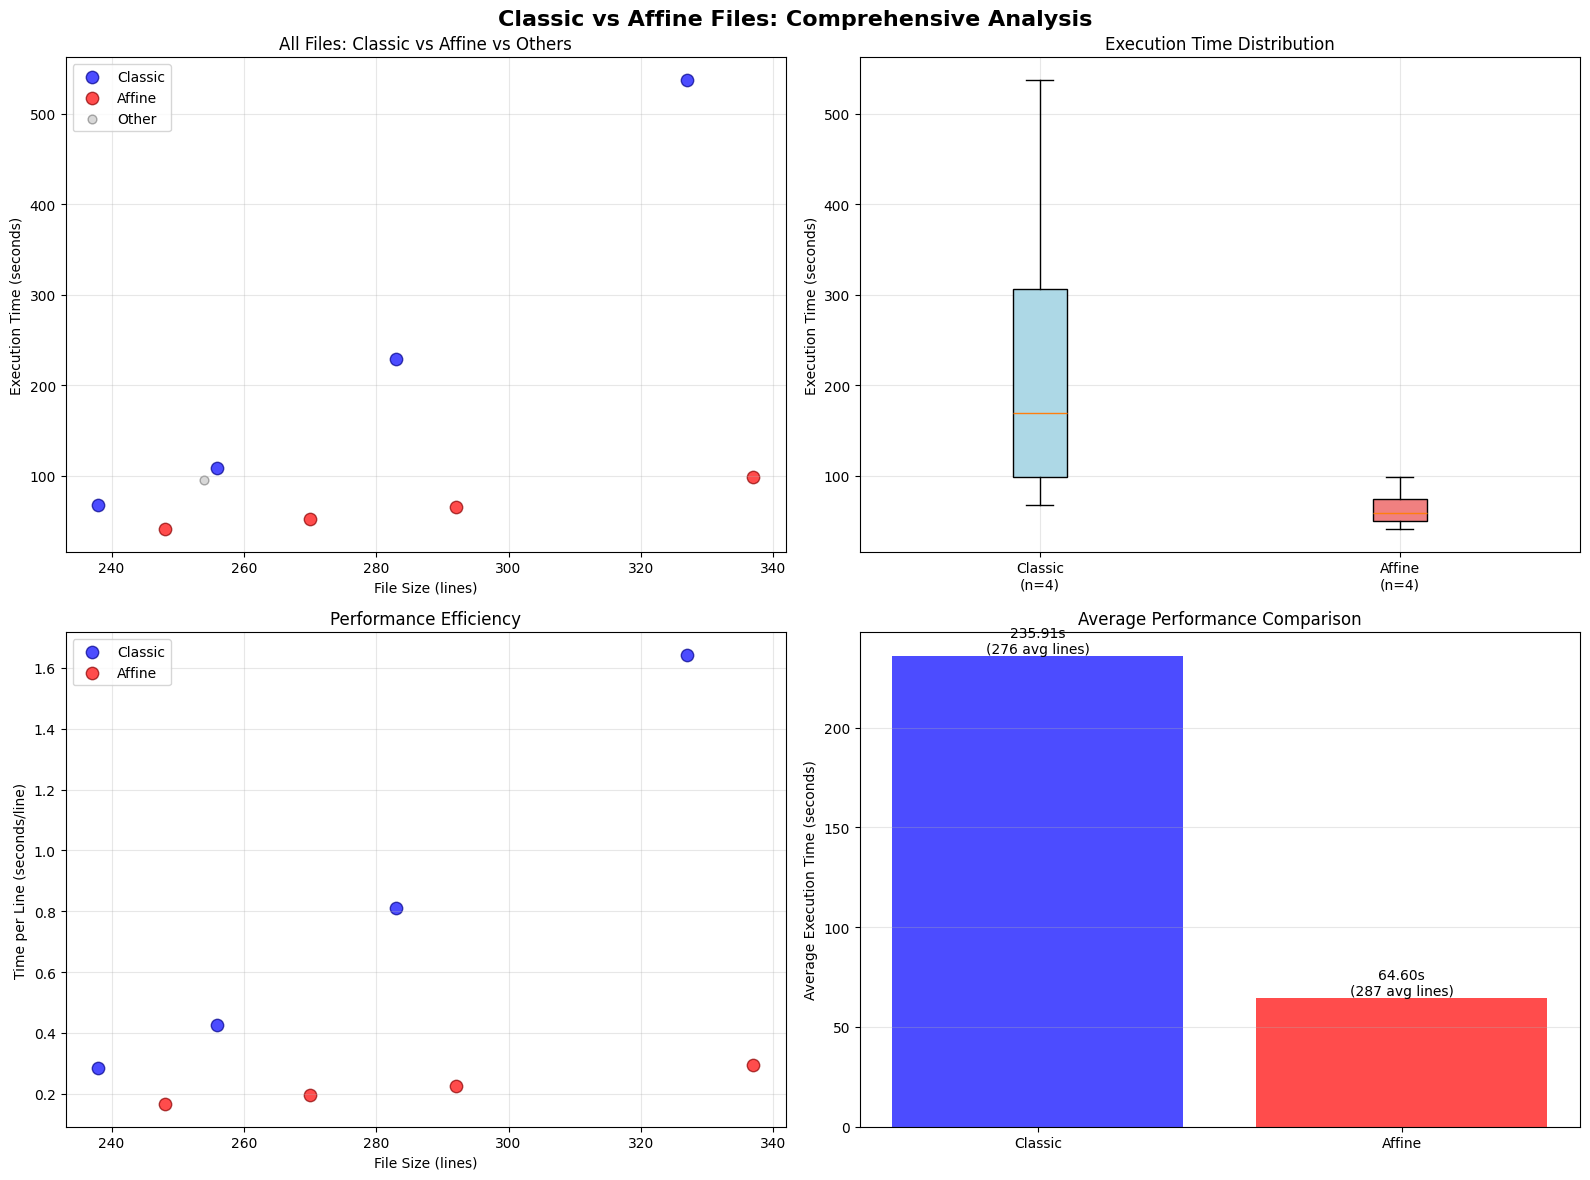

In [81]:
# Cell: Extended Classic vs Affine Analysis
if df is not None:
    # Filter files by name patterns (case insensitive)
    classic_files = df[df['filename'].str.contains('classic', case=False, na=False)]
    affine_files = df[df['filename'].str.contains('affine', case=False, na=False)]
    other_files = df[~df['filename'].str.contains('classic|affine', case=False, na=False)]
    
    if len(classic_files) > 0 or len(affine_files) > 0:
        # Create a comprehensive comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Classic vs Affine Files: Comprehensive Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Scatter plots side by side
        if len(classic_files) > 0:
            ax1.scatter(classic_files['line_count'], classic_files['execution_time_seconds'], 
                       alpha=0.7, s=80, c='blue', label='Classic', edgecolors='darkblue')
        if len(affine_files) > 0:
            ax1.scatter(affine_files['line_count'], affine_files['execution_time_seconds'], 
                       alpha=0.7, s=80, c='red', label='Affine', edgecolors='darkred')
        if len(other_files) > 0:
            ax1.scatter(other_files['line_count'], other_files['execution_time_seconds'], 
                       alpha=0.3, s=40, c='gray', label='Other', edgecolors='black')
        
        ax1.set_xlabel('File Size (lines)')
        ax1.set_ylabel('Execution Time (seconds)')
        ax1.set_title('All Files: Classic vs Affine vs Others')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Box plots for comparison
        data_to_plot = []
        labels = []
        if len(classic_files) > 0:
            data_to_plot.append(classic_files['execution_time_seconds'])
            labels.append(f'Classic\n(n={len(classic_files)})')
        if len(affine_files) > 0:
            data_to_plot.append(affine_files['execution_time_seconds'])
            labels.append(f'Affine\n(n={len(affine_files)})')
        
        if data_to_plot:
            bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
            colors = ['lightblue', 'lightcoral']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
        
        ax2.set_ylabel('Execution Time (seconds)')
        ax2.set_title('Execution Time Distribution')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Performance efficiency (time per line)
        if len(classic_files) > 0:
            classic_efficiency = classic_files['execution_time_seconds'] / classic_files['line_count']
            ax3.scatter(classic_files['line_count'], classic_efficiency, 
                       alpha=0.7, s=80, c='blue', label='Classic', edgecolors='darkblue')
        if len(affine_files) > 0:
            affine_efficiency = affine_files['execution_time_seconds'] / affine_files['line_count']
            ax3.scatter(affine_files['line_count'], affine_efficiency, 
                       alpha=0.7, s=80, c='red', label='Affine', edgecolors='darkred')
        
        ax3.set_xlabel('File Size (lines)')
        ax3.set_ylabel('Time per Line (seconds/line)')
        ax3.set_title('Performance Efficiency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Bar chart of averages
        categories = []
        avg_times = []
        avg_sizes = []
        
        if len(classic_files) > 0:
            categories.append('Classic')
            avg_times.append(classic_files['execution_time_seconds'].mean())
            avg_sizes.append(classic_files['line_count'].mean())
        
        if len(affine_files) > 0:
            categories.append('Affine')
            avg_times.append(affine_files['execution_time_seconds'].mean())
            avg_sizes.append(affine_files['line_count'].mean())
        
        if categories:
            x_pos = np.arange(len(categories))
            bars = ax4.bar(x_pos, avg_times, alpha=0.7, 
                          color=['blue' if cat == 'Classic' else 'red' for cat in categories])
            
            # Add value labels on bars
            for bar, time, size in zip(bars, avg_times, avg_sizes):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{time:.2f}s\n({size:.0f} avg lines)', 
                        ha='center', va='bottom', fontsize=10)
            
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(categories)
            ax4.set_ylabel('Average Execution Time (seconds)')
            ax4.set_title('Average Performance Comparison')
            ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()


# Verification performance analysis

In [82]:
# Cell 1: Import libraries and setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import re

# Set up matplotlib for better plots
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("📊 Verification Performance Analysis Notebook")
print("=" * 50)

📊 Verification Performance Analysis Notebook


In [83]:
# Cell 2: Load and examine the data
def load_verification_results(csv_file="results.csv"):
    """Load verification results from CSV file."""
    
    if not Path(csv_file).exists():
        print(f"❌ Error: CSV file '{csv_file}' not found")
        return None
    
    try:
        df = pd.read_csv(csv_file)
        print(f"✅ Loaded {len(df)} results from {csv_file}")
        return df
    except Exception as e:
        print(f"❌ Error reading CSV file: {e}")
        return None

In [84]:
# Load the data
df = load_verification_results("results_01.08.2025.csv")

# Display basic info about the dataset
if df is not None:
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    display(df.head())
    
    # Check for any failed lake commands
    failed_lake = df[df['status'] == 'lake_failed']
    if len(failed_lake) > 0:
        print(f"\n⚠️  {len(failed_lake)} files failed at lake stage:")
        display(failed_lake[['filename', 'status']])

✅ Loaded 6 results from results_01.08.2025.csv

Dataset shape: (6, 8)
Columns: ['filename', 'lake_time_seconds', 'smt2_replay_time_seconds', 'sat_count', 'unsat_count', 'unknown_count', 'error_count', 'status']


,filename,lake_time_seconds,smt2_replay_time_seconds,sat_count,unsat_count,unknown_count,error_count,status
0,Strata/Languages/Boogie/Examples/ContainerHeap...,39.189323,0.472639,0,26,0,0,ok_26_0
1,Strata/Languages/Boogie/Examples/ContainerHeap...,51.873260,0.465826,0,26,0,0,ok_26_0
2,Strata/Languages/Boogie/Examples/ContainerHeap...,71.207261,0.488293,0,26,0,0,ok_26_0
3,Strata/Languages/Boogie/Examples/ContainerHeap...,111.394035,0.513213,0,26,0,0,ok_26_0
4,Strata/Languages/Boogie/Examples/ContainerHeap...,70.853253,0.474001,0,27,0,0,ok_27_0



⚠️  1 files failed at lake stage:


,filename,status
5,Strata/Languages/Boogie/Examples/ContainerHeap...,lake_failed


In [85]:
# Cell 3: Categorize files by type (affine, classic, other)
if df is not None:
    def categorize_file(filename):
        """Categorize files based on filename patterns"""
        filename_lower = filename.lower()
        if 'affine' in filename_lower:
            return 'affine'
        elif 'classic' in filename_lower:
            return 'classic'
        else:
            return 'other'
    
    # Add category column
    df['category'] = df['filename'].apply(categorize_file)
    
    # Show category distribution
    category_counts = df['category'].value_counts()
    print("📂 File Categories:")
    print("=" * 30)
    for category, count in category_counts.items():
        print(f"{category.capitalize()}: {count} files")
    
    # Show some examples from each category
    print(f"\n📋 Examples by Category:")
    for category in ['affine', 'classic', 'other']:
        examples = df[df['category'] == category]['filename'].head(3).tolist()
        if examples:
            print(f"\n{category.capitalize()} files:")
            for example in examples:
                print(f"  • {Path(example).name}")


📂 File Categories:
Affine: 4 files
Classic: 2 files

📋 Examples by Category:

Affine files:
  • ContainerHeapAffine4.boogie.st
  • ContainerHeapAffine8.boogie.st
  • ContainerHeapAffine12.boogie.st

Classic files:
  • ContainerHeapClassic4.boogie.st
  • ContainerHeapClassic8.boogie.st


In [86]:
# Cell 4: Overall Performance Summary
if df is not None:
    print("📊 OVERALL PERFORMANCE SUMMARY")
    print("=" * 50)
    
    # Filter out failed lake commands for performance analysis
    valid_df = df[df['status'] != 'lake_failed'].copy()
    
    if len(valid_df) > 0:
        print(f"Valid files for analysis: {len(valid_df)}")
        print(f"Average Lake time: {valid_df['lake_time_seconds'].mean():.2f}s")
        print(f"Average SMT2 replay time: {valid_df['smt2_replay_time_seconds'].mean():.2f}s")
        print(f"Total verification time: {(valid_df['lake_time_seconds'] + valid_df['smt2_replay_time_seconds']).sum():.2f}s")
        
        # SMT2 results summary
        print(f"\n🔍 SMT2 Results Summary:")
        print(f"Total SAT results: {valid_df['sat_count'].sum()}")
        print(f"Total UNSAT results: {valid_df['unsat_count'].sum()}")
        print(f"Total UNKNOWN results: {valid_df['unknown_count'].sum()}")
        print(f"Total ERROR results: {valid_df['error_count'].sum()}")
        
        # Success rate
        total_smt2_queries = valid_df['sat_count'].sum() + valid_df['unsat_count'].sum() + valid_df['unknown_count'].sum() + valid_df['error_count'].sum()
        successful_queries = valid_df['sat_count'].sum() + valid_df['unsat_count'].sum()
        if total_smt2_queries > 0:
            success_rate = (successful_queries / total_smt2_queries) * 100
            print(f"Overall SMT2 success rate: {success_rate:.1f}%")
        
        # Display detailed statistics
        print(f"\n📈 Detailed Statistics:")
        display(valid_df[['lake_time_seconds', 'smt2_replay_time_seconds', 'sat_count', 'unsat_count', 'unknown_count', 'error_count']].describe())
    else:
        print("❌ No valid files for analysis")

📊 OVERALL PERFORMANCE SUMMARY
Valid files for analysis: 5
Average Lake time: 68.90s
Average SMT2 replay time: 0.48s
Total verification time: 346.93s

🔍 SMT2 Results Summary:
Total SAT results: 0
Total UNSAT results: 131
Total UNKNOWN results: 0
Total ERROR results: 0
Overall SMT2 success rate: 100.0%

📈 Detailed Statistics:


,lake_time_seconds,smt2_replay_time_seconds,sat_count,unsat_count,unknown_count,error_count
count,5.000000,5.000000,5.0,5.000000,5.0,5.0
mean,68.903426,0.482794,0.0,26.200000,0.0,0.0
std,27.329086,0.018867,0.0,0.447214,0.0,0.0
min,39.189323,0.465826,0.0,26.000000,0.0,0.0
25%,51.873260,0.472639,0.0,26.000000,0.0,0.0
50%,70.853253,0.474001,0.0,26.000000,0.0,0.0
75%,71.207261,0.488293,0.0,26.000000,0.0,0.0
max,111.394035,0.513213,0.0,27.000000,0.0,0.0


In [87]:
# Cell 5: Performance by Category Analysis
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    
    if len(valid_df) > 0:
        print("📊 PERFORMANCE BY CATEGORY")
        print("=" * 50)
        
        # Calculate total time
        valid_df['total_time'] = valid_df['lake_time_seconds'] + valid_df['smt2_replay_time_seconds']
        valid_df['total_smt2_queries'] = valid_df['sat_count'] + valid_df['unsat_count'] + valid_df['unknown_count'] + valid_df['error_count']
        
        # Group by category
        category_stats = valid_df.groupby('category').agg({
            'lake_time_seconds': ['mean', 'median', 'std', 'count'],
            'smt2_replay_time_seconds': ['mean', 'median', 'std'],
            'total_time': ['mean', 'median', 'std'],
            'sat_count': 'sum',
            'unsat_count': 'sum',
            'unknown_count': 'sum',
            'error_count': 'sum',
            'total_smt2_queries': 'sum'
        }).round(3)
        
        # Flatten column names
        category_stats.columns = [f"{col[0]}_{col[1]}" for col in category_stats.columns]
        category_stats = category_stats.reset_index()
        
        display(category_stats)
        
        # Calculate success rates by category
        print(f"\n🎯 Success Rates by Category:")
        for category in valid_df['category'].unique():
            cat_data = valid_df[valid_df['category'] == category]
            total_queries = cat_data['total_smt2_queries'].sum()
            successful_queries = cat_data['sat_count'].sum() + cat_data['unsat_count'].sum()
            if total_queries > 0:
                success_rate = (successful_queries / total_queries) * 100
                print(f"{category.capitalize()}: {success_rate:.1f}% ({successful_queries}/{total_queries})")

📊 PERFORMANCE BY CATEGORY


,category,lake_time_seconds_mean,lake_time_seconds_median,lake_time_seconds_std,lake_time_seconds_count,smt2_replay_time_seconds_mean,smt2_replay_time_seconds_median,smt2_replay_time_seconds_std,total_time_mean,total_time_median,total_time_std,sat_count_sum,unsat_count_sum,unknown_count_sum,error_count_sum,total_smt2_queries_sum
0,affine,68.416,61.540,31.532,4,0.485,0.480,0.021,68.901,62.017,31.552,0,104,0,0,104
1,classic,70.853,70.853,NaN,1,0.474,0.474,NaN,71.327,71.327,NaN,0,27,0,0,27



🎯 Success Rates by Category:
Affine: 100.0% (104/104)
Classic: 100.0% (27/27)


/var/folders/p5/ks5m_6tn0cl9zk8rttvqpqyh0000gq/T/ipykernel_37548/668673336.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_for_box, labels=[cat.capitalize() for cat in categories], patch_artist=True)


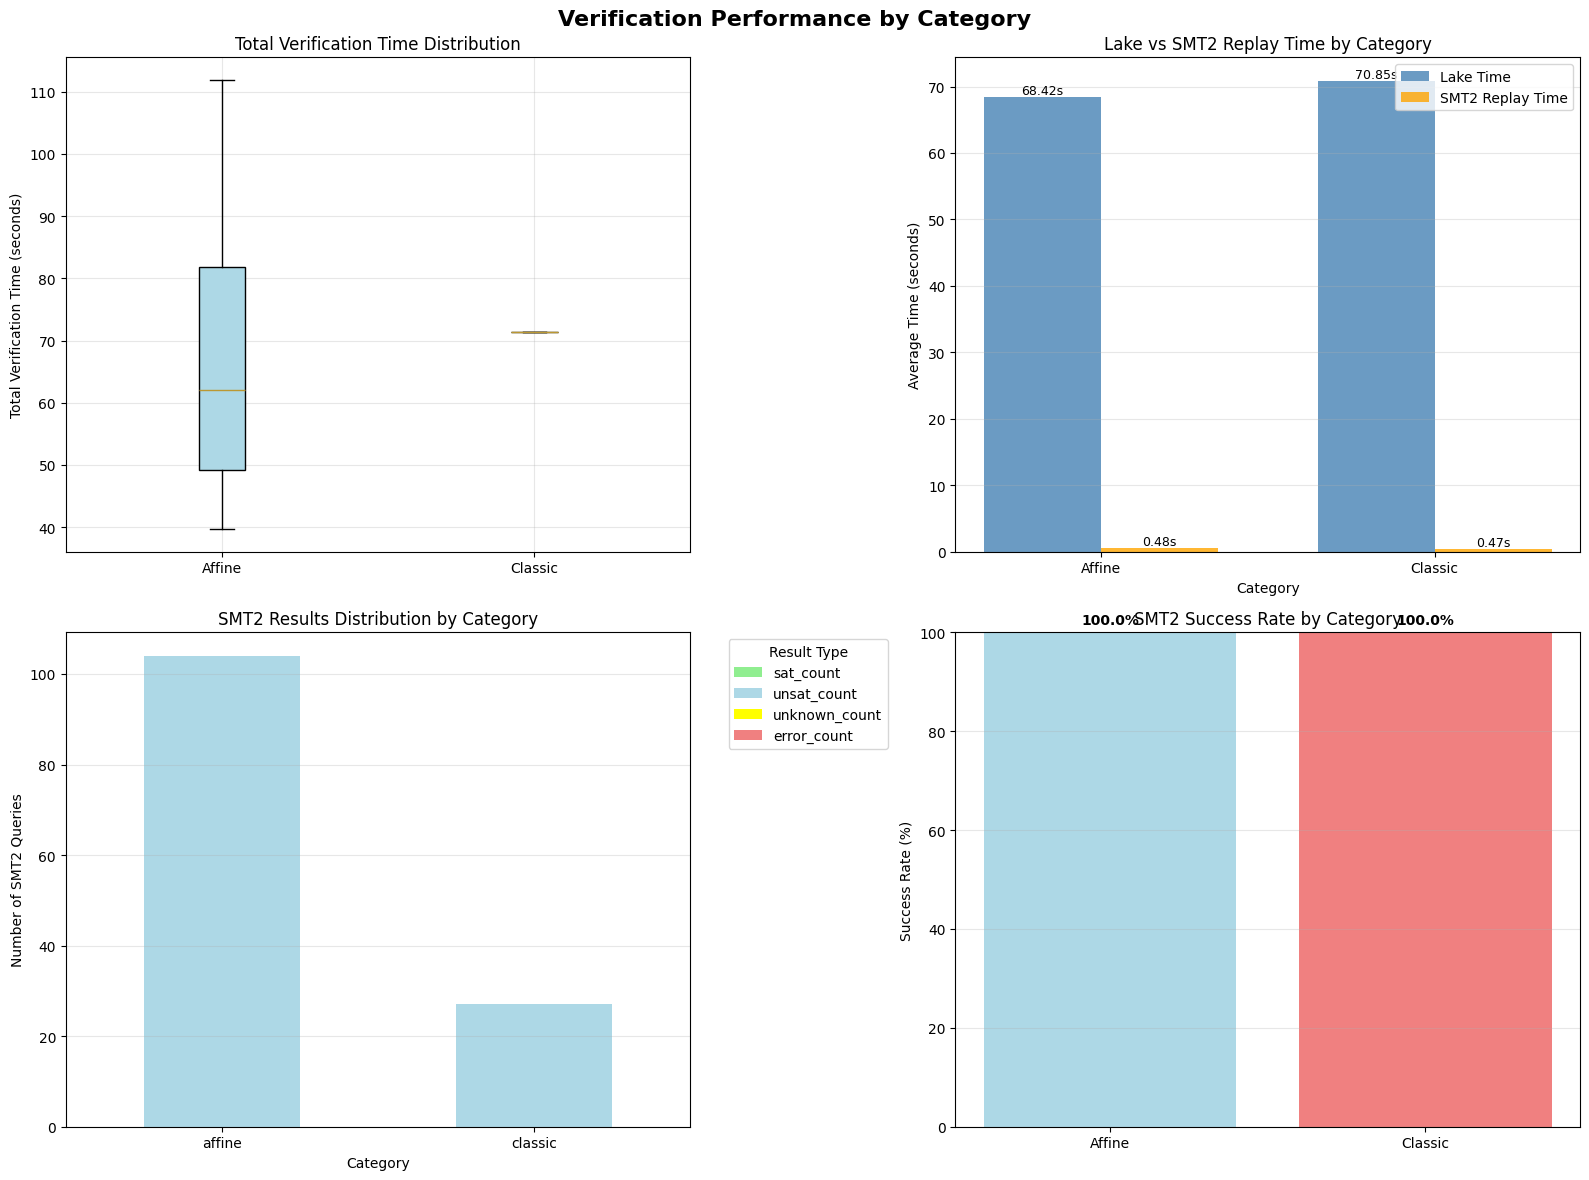

In [88]:
# Cell 6: Visualization - Performance Comparison by Category
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    valid_df['total_time'] = valid_df['lake_time_seconds'] + valid_df['smt2_replay_time_seconds']
    
    if len(valid_df) > 0:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Verification Performance by Category', fontsize=16, fontweight='bold')
        
        # 1. Box plot of total verification times
        categories = valid_df['category'].unique()
        data_for_box = [valid_df[valid_df['category'] == cat]['total_time'] for cat in categories]
        
        bp1 = ax1.boxplot(data_for_box, labels=[cat.capitalize() for cat in categories], patch_artist=True)
        colors = ['lightblue', 'lightcoral', 'lightgreen']
        for patch, color in zip(bp1['boxes'], colors[:len(bp1['boxes'])]):
            patch.set_facecolor(color)
        
        ax1.set_ylabel('Total Verification Time (seconds)')
        ax1.set_title('Total Verification Time Distribution')
        ax1.grid(True, alpha=0.3)
        
        # 2. Lake vs SMT2 time comparison
        category_means = valid_df.groupby('category')[['lake_time_seconds', 'smt2_replay_time_seconds']].mean()
        
        x = np.arange(len(category_means))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, category_means['lake_time_seconds'], width, 
                       label='Lake Time', alpha=0.8, color='steelblue')
        bars2 = ax2.bar(x + width/2, category_means['smt2_replay_time_seconds'], width,
                       label='SMT2 Replay Time', alpha=0.8, color='orange')
        
        ax2.set_xlabel('Category')
        ax2.set_ylabel('Average Time (seconds)')
        ax2.set_title('Lake vs SMT2 Replay Time by Category')
        ax2.set_xticks(x)
        ax2.set_xticklabels([cat.capitalize() for cat in category_means.index])
        ax2.legend( loc='upper right')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}s', ha='center', va='bottom', fontsize=9)
        
        # 3. SMT2 Results by Category (Stacked Bar)
        smt2_results = valid_df.groupby('category')[['sat_count', 'unsat_count', 'unknown_count', 'error_count']].sum()
        
        smt2_results.plot(kind='bar', stacked=True, ax=ax3, 
                         color=['lightgreen', 'lightblue', 'yellow', 'lightcoral'])
        ax3.set_xlabel('Category')
        ax3.set_ylabel('Number of SMT2 Queries')
        ax3.set_title('SMT2 Results Distribution by Category')
        ax3.legend(title='Result Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3, axis='y')
        plt.setp(ax3.get_xticklabels(), rotation=0)
        
        # 4. Success Rate by Category
        success_rates = []
        categories_list = []
        for category in valid_df['category'].unique():
            cat_data = valid_df[valid_df['category'] == category]
            total_queries = cat_data['sat_count'].sum() + cat_data['unsat_count'].sum() + cat_data['unknown_count'].sum() + cat_data['error_count'].sum()
            successful_queries = cat_data['sat_count'].sum() + cat_data['unsat_count'].sum()
            if total_queries > 0:
                success_rate = (successful_queries / total_queries) * 100
                success_rates.append(success_rate)
                categories_list.append(category.capitalize())
        
        bars4 = ax4.bar(categories_list, success_rates, color=['lightblue', 'lightcoral', 'lightgreen'][:len(categories_list)])
        ax4.set_ylabel('Success Rate (%)')
        ax4.set_title('SMT2 Success Rate by Category')
        ax4.set_ylim(0, 100)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on bars
        for bar, rate in zip(bars4, success_rates):
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()


In [89]:
# Cell 7: Detailed Analysis - Top Performers and Slowest Files
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    valid_df['total_time'] = valid_df['lake_time_seconds'] + valid_df['smt2_replay_time_seconds']
    
    if len(valid_df) > 0:
        print("🏆 TOP PERFORMERS AND SLOWEST FILES")
        print("=" * 50)
        
        # Top 10 fastest files
        fastest_files = valid_df.nsmallest(10, 'total_time')
        print(f"\n⚡ Top 10 Fastest Files:")
        display(fastest_files[['filename', 'category', 'total_time', 'sat_count', 'unsat_count', 'error_count']].round(3))
        
        # Top 10 slowest files
        slowest_files = valid_df.nlargest(10, 'total_time')
        print(f"\n🐌 Top 10 Slowest Files:")
        display(slowest_files[['filename', 'category', 'total_time', 'sat_count', 'unsat_count', 'error_count']].round(3))
        

🏆 TOP PERFORMERS AND SLOWEST FILES

⚡ Top 10 Fastest Files:


,filename,category,total_time,sat_count,unsat_count,error_count
0,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,39.662,0,26,0
1,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,52.339,0,26,0
4,Strata/Languages/Boogie/Examples/ContainerHeap...,classic,71.327,0,27,0
2,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,71.696,0,26,0
3,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,111.907,0,26,0



🐌 Top 10 Slowest Files:


,filename,category,total_time,sat_count,unsat_count,error_count
3,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,111.907,0,26,0
2,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,71.696,0,26,0
4,Strata/Languages/Boogie/Examples/ContainerHeap...,classic,71.327,0,27,0
1,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,52.339,0,26,0
0,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,39.662,0,26,0


🔗 CORRELATION ANALYSIS


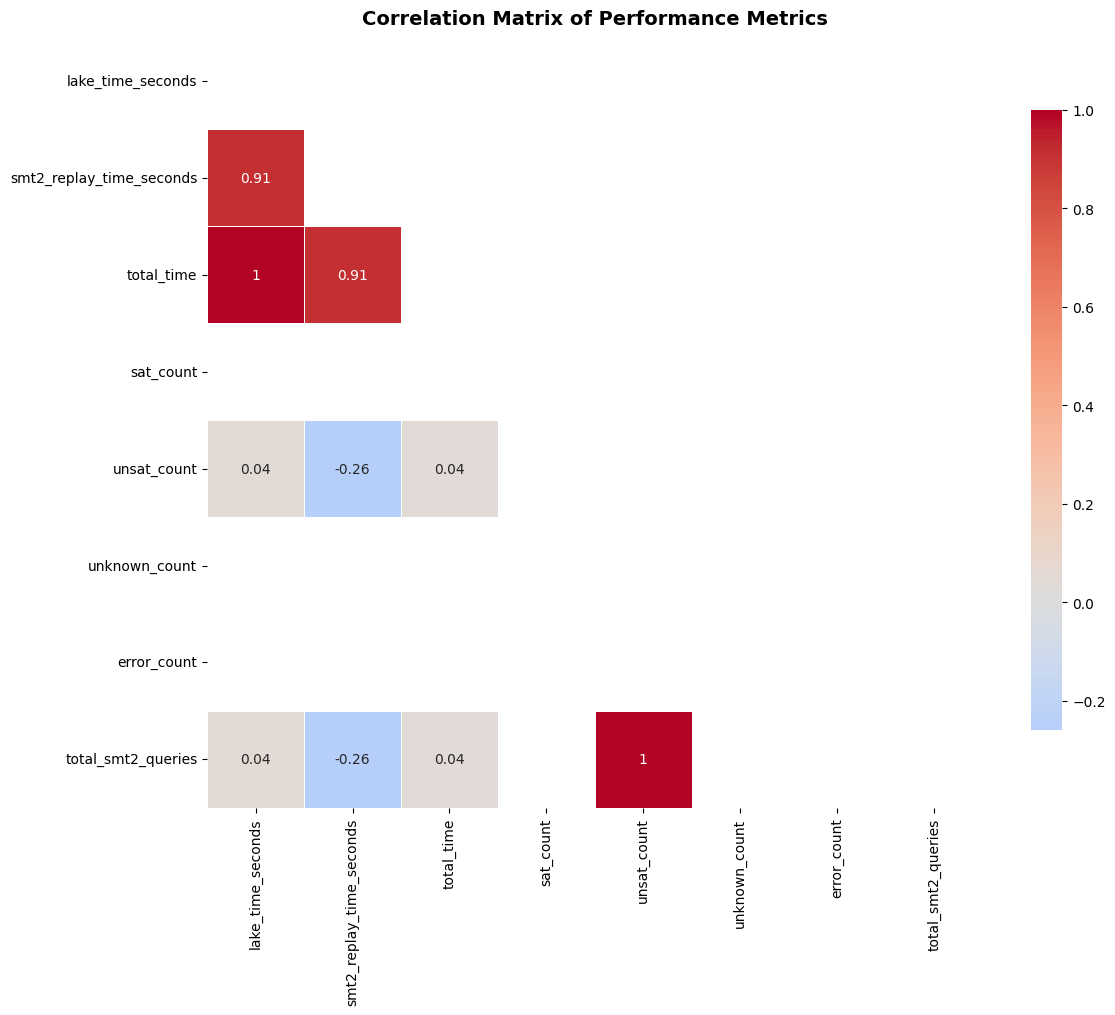


🔍 Key Correlations:
Lake time vs SMT2 time: 0.911
Total time vs Number of queries: 0.040
  → Weak correlation: Number of queries doesn't strongly predict verification time


In [90]:
# Cell 8: Correlation Analysis
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    valid_df['total_time'] = valid_df['lake_time_seconds'] + valid_df['smt2_replay_time_seconds']
    valid_df['total_smt2_queries'] = valid_df['sat_count'] + valid_df['unsat_count'] + valid_df['unknown_count'] + valid_df['error_count']
    
    if len(valid_df) > 0:
        print("🔗 CORRELATION ANALYSIS")
        print("=" * 30)
        
        # Calculate correlations
        numeric_cols = ['lake_time_seconds', 'smt2_replay_time_seconds', 'total_time', 
                       'sat_count', 'unsat_count', 'unknown_count', 'error_count', 'total_smt2_queries']
        
        correlation_matrix = valid_df[numeric_cols].corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Correlation Matrix of Performance Metrics', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Key insights
        print(f"\n🔍 Key Correlations:")
        lake_smt2_corr = correlation_matrix.loc['lake_time_seconds', 'smt2_replay_time_seconds']
        time_queries_corr = correlation_matrix.loc['total_time', 'total_smt2_queries']
        
        print(f"Lake time vs SMT2 time: {lake_smt2_corr:.3f}")
        print(f"Total time vs Number of queries: {time_queries_corr:.3f}")
        
        if time_queries_corr > 0.7:
            print("  → Strong positive correlation: More queries = longer verification time")
        elif time_queries_corr > 0.3:
            print("  → Moderate positive correlation: More queries tend to increase verification time")
        else:
            print("  → Weak correlation: Number of queries doesn't strongly predict verification time")

In [91]:
# Cell 9: Category-Specific Deep Dive
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    valid_df['total_time'] = valid_df['lake_time_seconds'] + valid_df['smt2_replay_time_seconds']
    
    if len(valid_df) > 0:
        print("🔬 CATEGORY-SPECIFIC DEEP DIVE")
        print("=" * 40)
        
        for category in ['affine', 'classic', 'other']:
            cat_data = valid_df[valid_df['category'] == category]
            
            if len(cat_data) > 0:
                print(f"\n📊 {category.upper()} FILES ANALYSIS:")
                print("-" * 30)
                print(f"Count: {len(cat_data)}")
                print(f"Avg total time: {cat_data['total_time'].mean():.2f}s")
                print(f"Median total time: {cat_data['total_time'].median():.2f}s")
                print(f"Std deviation: {cat_data['total_time'].std():.2f}s")
                print(f"Min time: {cat_data['total_time'].min():.2f}s")
                print(f"Max time: {cat_data['total_time'].max():.2f}s")
                
                # SMT2 breakdown
                total_smt2 = cat_data['sat_count'].sum() + cat_data['unsat_count'].sum() + cat_data['unknown_count'].sum() + cat_data['error_count'].sum()
                if total_smt2 > 0:
                    print(f"SMT2 queries: {total_smt2} total")
                    print(f"  - SAT: {cat_data['sat_count'].sum()} ({cat_data['sat_count'].sum()/total_smt2*100:.1f}%)")
                    print(f"  - UNSAT: {cat_data['unsat_count'].sum()} ({cat_data['unsat_count'].sum()/total_smt2*100:.1f}%)")
                    print(f"  - UNKNOWN: {cat_data['unknown_count'].sum()} ({cat_data['unknown_count'].sum()/total_smt2*100:.1f}%)")
                    print(f"  - ERROR: {cat_data['error_count'].sum()} ({cat_data['error_count'].sum()/total_smt2*100:.1f}%)")
                
                # Show most representative files
                print(f"Most representative files:")
                median_time = cat_data['total_time'].median()
                closest_to_median = cat_data.iloc[(cat_data['total_time'] - median_time).abs().argsort()[:3]]
                for _, row in closest_to_median.iterrows():
                    print(f"  • {Path(row['filename']).name}: {row['total_time']:.2f}s")



🔬 CATEGORY-SPECIFIC DEEP DIVE

📊 AFFINE FILES ANALYSIS:
------------------------------
Count: 4
Avg total time: 68.90s
Median total time: 62.02s
Std deviation: 31.55s
Min time: 39.66s
Max time: 111.91s
SMT2 queries: 104 total
  - SAT: 0 (0.0%)
  - UNSAT: 104 (100.0%)
  - UNKNOWN: 0 (0.0%)
  - ERROR: 0 (0.0%)
Most representative files:
  • ContainerHeapAffine8.boogie.st: 52.34s
  • ContainerHeapAffine12.boogie.st: 71.70s
  • ContainerHeapAffine4.boogie.st: 39.66s

📊 CLASSIC FILES ANALYSIS:
------------------------------
Count: 1
Avg total time: 71.33s
Median total time: 71.33s
Std deviation: nans
Min time: 71.33s
Max time: 71.33s
SMT2 queries: 27 total
  - SAT: 0 (0.0%)
  - UNSAT: 27 (100.0%)
  - UNKNOWN: 0 (0.0%)
  - ERROR: 0 (0.0%)
Most representative files:
  • ContainerHeapClassic4.boogie.st: 71.33s


In [92]:
# Cell: Enhanced Performance vs Number of Calls Analysis
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    
    def extract_number_from_filename_enhanced(filename):
        """Enhanced number extraction with multiple strategies"""
        basename = Path(filename).stem
        
        # Strategy 1: Look for numbers at the end of filename (most common)
        end_numbers = re.findall(r'(\d+)(?:\.|$)', basename)
        if end_numbers:
            return int(end_numbers[-1])
        
        # Strategy 2: Look for numbers after specific keywords
        patterns = [
            r'calls?(\d+)',
            r'iter(?:ation)?(\d+)',
            r'step(\d+)',
            r'n(\d+)',
            r'(\d+)calls?',
        ]
        
        for pattern in patterns:
            matches = re.findall(pattern, basename.lower())
            if matches:
                return int(matches[0])
        
        # Strategy 3: Take the largest number in the filename
        all_numbers = re.findall(r'\d+', basename)
        if all_numbers:
            numbers = [int(n) for n in all_numbers]
            # Filter out very small numbers (likely version numbers) and very large ones
            filtered_numbers = [n for n in numbers if 1 <= n <= 1000]
            if filtered_numbers:
                return max(filtered_numbers)
            return max(numbers)
        
        return None
    
    # Extract number of calls from filename
    valid_df['num_calls'] = valid_df['filename'].apply(extract_number_from_filename_enhanced)
    
    # Filter out files where we couldn't extract a number
    df_with_calls = valid_df[valid_df['num_calls'].notna()].copy()
    
    if len(df_with_calls) > 0:
        print(f"📊 Enhanced extraction found {len(df_with_calls)} files with call numbers")
        print(f"Call numbers range: {df_with_calls['num_calls'].min()} to {df_with_calls['num_calls'].max()}")
        
        # Show distribution of call numbers
        call_dist = df_with_calls['num_calls'].value_counts().sort_index()
        print(f"Call number distribution: {dict(call_dist.head(10))}")
        
        # Rest of the plotting code remains the same...
        # [Include the same plotting code from the previous cell]
        
    else:
        print("❌ Enhanced extraction could not find call numbers")
        print("Please check filename patterns. Examples:")
        for filename in valid_df['filename'].head(5):
            print(f"  • {Path(filename).name}")


📊 Enhanced extraction found 5 files with call numbers
Call numbers range: 4 to 20
Call number distribution: {4: np.int64(2), 8: np.int64(1), 12: np.int64(1), 20: np.int64(1)}


📊 Found 5 files with extractable call numbers
Call numbers range: 4 to 20
Classic files: 1
Affine files: 4
Other files: 0


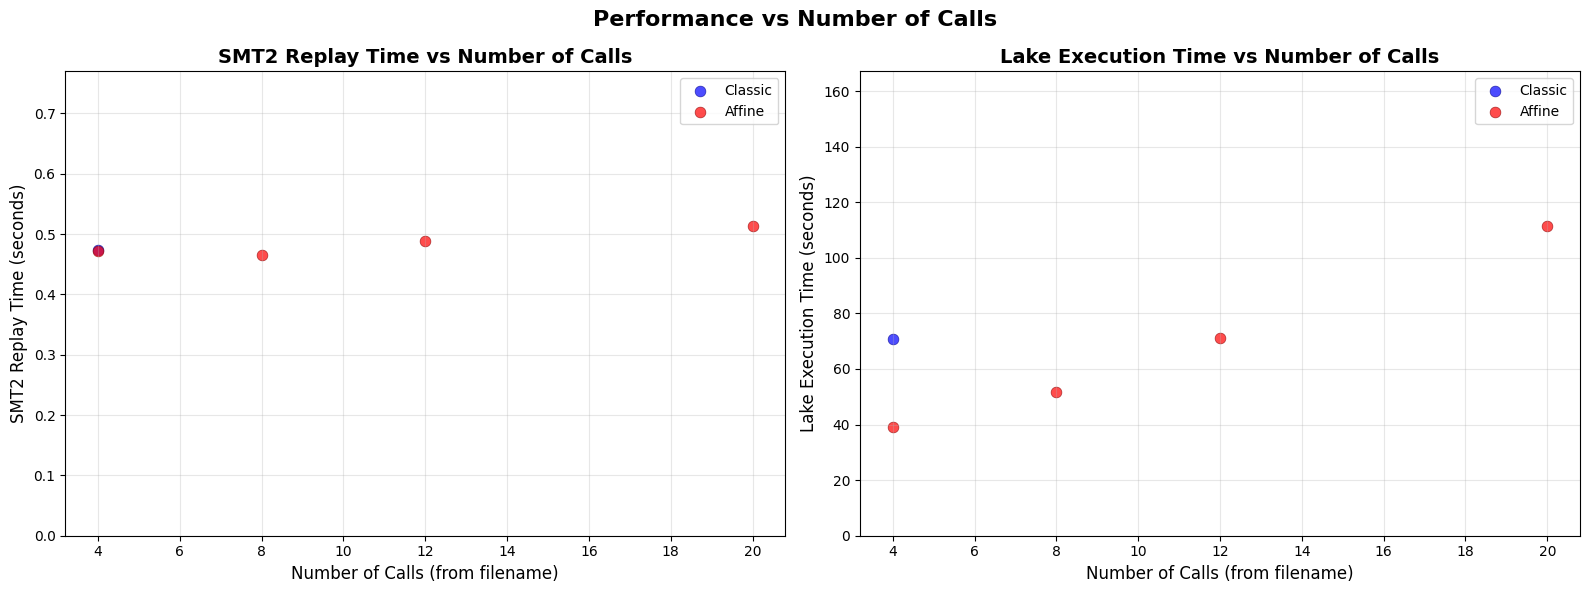


📈 Statistical Analysis:

📋 Example Files with Extracted Call Numbers:


,filename,category,num_calls,smt2_replay_time_seconds,lake_time_seconds
0,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,4,0.472639,39.189323
4,Strata/Languages/Boogie/Examples/ContainerHeap...,classic,4,0.474001,70.853253
1,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,8,0.465826,51.873260
2,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,12,0.488293,71.207261
3,Strata/Languages/Boogie/Examples/ContainerHeap...,affine,20,0.513213,111.394035


In [100]:
# Cell: Performance vs Number of Calls Analysis
if df is not None:
    valid_df = df[df['status'] != 'lake_failed'].copy()
    
    def extract_number_from_filename(filename):
        """Extract number from filename (assuming it appears as a digit sequence)"""
        # Look for numbers in the filename
        numbers = re.findall(r'\d+', Path(filename).stem)
        if numbers:
            # Return the last number found (often the most relevant)
            return int(numbers[-1])
        return None
    
    # Extract number of calls from filename
    valid_df['num_calls'] = valid_df['filename'].apply(extract_number_from_filename)
    
    # Filter out files where we couldn't extract a number
    df_with_calls = valid_df[valid_df['num_calls'].notna()].copy()
    
    if len(df_with_calls) > 0:
        print(f"📊 Found {len(df_with_calls)} files with extractable call numbers")
        print(f"Call numbers range: {df_with_calls['num_calls'].min()} to {df_with_calls['num_calls'].max()}")
        
        # Separate classic and affine files
        classic_data = df_with_calls[df_with_calls['category'] == 'classic']
        affine_data = df_with_calls[df_with_calls['category'] == 'affine']
        other_data = df_with_calls[df_with_calls['category'] == 'other']

        max_y_smt2_replay = max(classic_data['smt2_replay_time_seconds'].max(), affine_data['smt2_replay_time_seconds'].max(), other_data['smt2_replay_time_seconds'].max())
        max_y_lake_time = max(classic_data['lake_time_seconds'].max(), affine_data['lake_time_seconds'].max(), other_data['lake_time_seconds'].max())

        print(f"Classic files: {len(classic_data)}")
        print(f"Affine files: {len(affine_data)}")
        print(f"Other files: {len(other_data)}")
        
        # Create the plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Performance vs Number of Calls', fontsize=16, fontweight='bold')
        
        # Plot 1: SMT2 Replay Time vs Number of Calls
        if len(classic_data) > 0:
            ax1.scatter(classic_data['num_calls'], classic_data['smt2_replay_time_seconds'], 
                       alpha=0.7, s=60, c='blue', label='Classic', edgecolors='darkblue', linewidth=0.5)
            
            # Add trend line for classic
            # if len(classic_data) > 1:
            #     z1 = np.polyfit(classic_data['num_calls'], classic_data['smt2_replay_time_seconds'], 1)
            #     p1 = np.poly1d(z1)
            #     ax1.plot(classic_data['num_calls'], p1(classic_data['num_calls']), 
            #             "b--", alpha=0.8, linewidth=2, label=f'Classic trend: y={z1[0]:.4f}x+{z1[1]:.2f}')
        
        if len(affine_data) > 0:
            ax1.scatter(affine_data['num_calls'], affine_data['smt2_replay_time_seconds'], 
                       alpha=0.7, s=60, c='red', label='Affine', edgecolors='darkred', linewidth=0.5)
            
            # Add trend line for affine
            # if len(affine_data) > 1:
            #     z2 = np.polyfit(affine_data['num_calls'], affine_data['smt2_replay_time_seconds'], 1)
            #     p2 = np.poly1d(z2)
            #     ax1.plot(affine_data['num_calls'], p2(affine_data['num_calls']), 
            #             "r--", alpha=0.8, linewidth=2, label=f'Affine trend: y={z2[0]:.4f}x+{z2[1]:.2f}')
        
        if len(other_data) > 0:
            ax1.scatter(other_data['num_calls'], other_data['smt2_replay_time_seconds'], 
                       alpha=0.5, s=40, c='gray', label='Other', edgecolors='black', linewidth=0.5)
        
        ax1.set_xlabel('Number of Calls (from filename)', fontsize=12)
        ax1.set_ylabel('SMT2 Replay Time (seconds)', fontsize=12)
        ax1.set_ylim(0, max_y_smt2_replay*1.5)
        ax1.set_title('SMT2 Replay Time vs Number of Calls', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Lake Execution Time vs Number of Calls
        if len(classic_data) > 0:
            ax2.scatter(classic_data['num_calls'], classic_data['lake_time_seconds'], 
                       alpha=0.7, s=60, c='blue', label='Classic', edgecolors='darkblue', linewidth=0.5)
            
            # Add trend line for classic
            # if len(classic_data) > 1:
            #     z3 = np.polyfit(classic_data['num_calls'], classic_data['lake_time_seconds'], 1)
            #     p3 = np.poly1d(z3)
            #     ax2.plot(classic_data['num_calls'], p3(classic_data['num_calls']), 
            #             "b--", alpha=0.8, linewidth=2, label=f'Classic trend: y={z3[0]:.4f}x+{z3[1]:.2f}')
        
        if len(affine_data) > 0:
            ax2.scatter(affine_data['num_calls'], affine_data['lake_time_seconds'], 
                       alpha=0.7, s=60, c='red', label='Affine', edgecolors='darkred', linewidth=0.5)
            
            # Add trend line for affine
            # if len(affine_data) > 1:
            #     z4 = np.polyfit(affine_data['num_calls'], affine_data['lake_time_seconds'], 1)
            #     p4 = np.poly1d(z4)
            #     ax2.plot(affine_data['num_calls'], p4(affine_data['num_calls']), 
            #             "r--", alpha=0.8, linewidth=2, label=f'Affine trend: y={z4[0]:.4f}x+{z4[1]:.2f}')
        
        if len(other_data) > 0:
            ax2.scatter(other_data['num_calls'], other_data['lake_time_seconds'], 
                       alpha=0.5, s=40, c='gray', label='Other', edgecolors='black', linewidth=0.5)
        
        ax2.set_xlabel('Number of Calls (from filename)', fontsize=12)
        ax2.set_ylabel('Lake Execution Time (seconds)', fontsize=12)
        ax2.set_ylim(0, max_y_lake_time*1.5)
        ax2.set_title('Lake Execution Time vs Number of Calls', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis
        print(f"\n📈 Statistical Analysis:")
        if len(classic_data) > 1 and len(affine_data) > 1:
            # Correlations
            classic_smt2_corr = classic_data['num_calls'].corr(classic_data['smt2_replay_time_seconds'])
            affine_smt2_corr = affine_data['num_calls'].corr(affine_data['smt2_replay_time_seconds'])
            classic_lake_corr = classic_data['num_calls'].corr(classic_data['lake_time_seconds'])
            affine_lake_corr = affine_data['num_calls'].corr(affine_data['lake_time_seconds'])
            
            print(f"SMT2 Time Correlations:")
            print(f"  Classic: {classic_smt2_corr:.3f}")
            print(f"  Affine:  {affine_smt2_corr:.3f}")
            print(f"Lake Time Correlations:")
            print(f"  Classic: {classic_lake_corr:.3f}")
            print(f"  Affine:  {affine_lake_corr:.3f}")
            
            # Performance comparison at different call numbers
            print(f"\n⚖️  Performance Comparison:")
            call_ranges = [(1, 5), (6, 10), (11, 20), (21, float('inf'))]
            
            for min_calls, max_calls in call_ranges:
                range_name = f"{min_calls}-{max_calls if max_calls != float('inf') else '∞'} calls"
                
                classic_range = classic_data[(classic_data['num_calls'] >= min_calls) & 
                                           (classic_data['num_calls'] <= max_calls)]
                affine_range = affine_data[(affine_data['num_calls'] >= min_calls) & 
                                         (affine_data['num_calls'] <= max_calls)]
                
                if len(classic_range) > 0 and len(affine_range) > 0:
                    classic_avg_smt2 = classic_range['smt2_replay_time_seconds'].mean()
                    affine_avg_smt2 = affine_range['smt2_replay_time_seconds'].mean()
                    classic_avg_lake = classic_range['lake_time_seconds'].mean()
                    affine_avg_lake = affine_range['lake_time_seconds'].mean()
                    
                    print(f"{range_name}:")
                    print(f"  SMT2 - Classic: {classic_avg_smt2:.3f}s, Affine: {affine_avg_smt2:.3f}s")
                    print(f"  Lake - Classic: {classic_avg_lake:.3f}s, Affine: {affine_avg_lake:.3f}s")
        
        # Show some example files with their extracted call numbers
        print(f"\n📋 Example Files with Extracted Call Numbers:")
        sample_files = df_with_calls.sample(min(10, len(df_with_calls)))[['filename', 'category', 'num_calls', 'smt2_replay_time_seconds', 'lake_time_seconds']]
        display(sample_files.sort_values('num_calls'))
        
    else:
        print("❌ Could not extract call numbers from any filenames")
        print("Example filenames:")
        for filename in valid_df['filename'].head(5):
            print(f"  • {Path(filename).name}")

